<a href="https://colab.research.google.com/github/Nilufayeasmin299/Phishig-detection-using-both-machine-learning-and-deep-learning-techniques/blob/main/1D_CNN_after_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#loading dataset
import pandas as pd
df=pd.read_csv('/content/gdrive/MyDrive/Second paper/Dataset/My new_data')
df.head()

,Unnamed: 0,having_IP_Address,URL_Length,Shortining_Service,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Redirect,on_mouseover,RightClick,age_of_domain,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,0,-1,1,1,-1,-1,-1,-1,1,-1,1,-1,0,1,1,-1,-1,-1,1,1,-1,0
1,1,1,1,1,-1,0,1,-1,1,0,-1,-1,0,1,1,-1,0,-1,1,1,1,0
2,2,1,0,1,-1,-1,-1,-1,1,0,-1,-1,0,1,1,1,1,-1,1,0,-1,0
3,3,1,0,1,-1,-1,-1,1,-1,0,0,-1,0,1,1,-1,1,-1,1,-1,1,0
4,4,1,0,-1,-1,1,1,-1,1,0,0,-1,0,-1,1,-1,0,-1,1,1,1,1


In [ ]:
df.columns

Index(['Unnamed: 0', 'having_IP_Address', 'URL_Length', 'Shortining_Service',
       'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Redirect', 'on_mouseover', 'RightClick',
       'age_of_domain', 'web_traffic', 'Page_Rank', 'Google_Index',
       'Links_pointing_to_page', 'Statistical_report', 'Result'],
      dtype='object')

In [ ]:
data=df.drop(['Unnamed: 0'], axis=1)

In [ ]:
data.head()

,having_IP_Address,URL_Length,Shortining_Service,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Redirect,on_mouseover,RightClick,age_of_domain,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,-1,-1,-1,-1,1,-1,1,-1,0,1,1,-1,-1,-1,1,1,-1,0
1,1,1,1,-1,0,1,-1,1,0,-1,-1,0,1,1,-1,0,-1,1,1,1,0
2,1,0,1,-1,-1,-1,-1,1,0,-1,-1,0,1,1,1,1,-1,1,0,-1,0
3,1,0,1,-1,-1,-1,1,-1,0,0,-1,0,1,1,-1,1,-1,1,-1,1,0
4,1,0,-1,-1,1,1,-1,1,0,0,-1,0,-1,1,-1,0,-1,1,1,1,1


In [ ]:
data.shape

(11055, 21)

In [ ]:
import numpy
from numpy import mean
from numpy import std
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import KFold
from keras.layers import Conv1D, MaxPooling1D, Flatten, Activation
import time

In [ ]:
import tensorflow as tf

In [ ]:
# lists to collect the performance metrics during each fold of the n-fold cross validation
accuracy=list()
loss=list()
recall=list()
f1=list()
precision=list()

In [ ]:
TrainTime=list()
TestTime=list()

In [ ]:
batch_size=32

In [ ]:
#create a dataframe with all the training data except the target column

X_train = array(df.drop(columns=['Result']))
y_train = array(df.Result)

In [ ]:
#input shape
n_cols = X_train.shape[1]

In [ ]:
number_of_folds = 10                            #number of folds in the n-fold cross validation - must have at least 2
current_fold=0
kfold = KFold(number_of_folds, True, 1)

In [ ]:
# function to fit and evaluate a CNN model on the dataset

def evaluate_1D_CNN_model(trainX, trainY, testX, testY, num_cols, fold):

    current_fold=fold            # the current fold in the n-fold cross validation
    dropout_rate=0.50
    n_cols = num_cols
    num_filters = 64             #number of filters in the convolutional layer
    size_filters=10               #size of the filters in convolutional layer
    start = time.time()

    # Reshape the inputs (training and testing inputs)
    trainX.shape=(trainX.shape[0],n_cols)
   # print(trainX.shape)
    trainX=trainX.reshape(trainX.shape[0], n_cols,1)
   
    #print(trainX.shape)
    testX.shape = (testX.shape[0], n_cols)
    #print(testX.shape)
    testX = testX.reshape(testX.shape[0], n_cols,1)
    
    #print(testX.shape)

    trainX = tf.convert_to_tensor(trainX,dtype=tf.float32)
    testX = tf.convert_to_tensor(testX,dtype=tf.float32)


    # define the model
    model = Sequential()
    model.add(Conv1D(num_filters, size_filters, input_shape=(num_cols, 1),use_bias=False))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(num_filters, 5,  use_bias=False))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Flatten())
    model.add(Dense(8, use_bias=False))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    

    # compile the model using accuracy as a measure of model performance
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
       

    #fit model
   
    history = model.fit(trainX, trainY, batch_size=batch_size, validation_split=0.1, epochs=20, verbose=0,)


    if current_fold ==1:                                                # show the model summary architecture when evaluating the 1st fold in the n-fold cross validation
        model.summary()

    # obtain approximate training time
    train_end_time = time.time()
    train_time = (train_end_time - start)     #obtain time taken to train the model
    TrainTime.append(train_time)

    #evaluate the model
    loss_score, acc_score = model.evaluate(testX, testY, verbose=0)
    loss.append(loss_score)
    accuracy.append(acc_score)

    y_pred = model.predict_classes(testX)

    # obtain approximate testing time
    test_time = (time.time() -train_end_time)        #obtain time taken to test the model
    TestTime.append(test_time)

    #update the list of performance metrics for the folds
    recall.append(recall_score(testY, y_pred))
    f1.append(f1_score(testY, y_pred))
    precision.append(precision_score(testY, y_pred))
    
    
   

    if current_fold == 1:                                                             #plot the test-validation loss and test-validation accuracy for fold 1
        from matplotlib import pyplot

        # plots ------
        pyplot.plot(history.history['loss'], label='training loss')
        pyplot.plot(history.history['val_loss'], label= 'validation loss')
        pyplot.legend()
        pyplot.show()
       # pyplot.plot(history.history['acc'], label='training acc')
        #pyplot.plot(history.history['val_acc'], label='validation acc')
        #pyplot.legend()
        #pyplot.show()

    return acc_score



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 64)            640       
_________________________________________________________________
activation (Activation)      (None, 12, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 64)             20480     
_________________________________________________________________
activation_1 (Activation)    (None, 2, 64)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


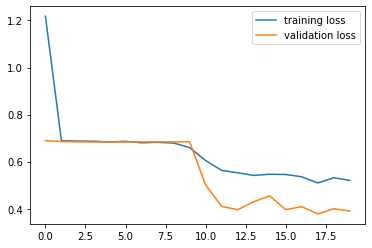

>0.932
>0.916
>0.914
>0.542
>0.932
>0.554
>0.924
>0.565
>0.561
>0.934


In [ ]:
#cross validation estimation of performance

scores = list()
for train_ix, test_ix in kfold.split(X_train):
    current_fold = current_fold+1
    #select samples
    trainX, trainY = X_train[train_ix], y_train[train_ix]
    testX, testY = X_train[test_ix], y_train[test_ix]

    #evaluate model
    
    acc_for_fold = evaluate_1D_CNN_model(trainX, trainY, testX, testY, n_cols, current_fold)
    print('>%.3f' % acc_for_fold)                 #output prediction accuracy for the current fold
    scores.append(acc_for_fold)

In [ ]:
# summarize the distribution of scores
print('Accuracy Mean: %.3f, Standard Deviation: %.3f' % (mean(accuracy), std(accuracy)))                   #mean of all the accuracies fom the n folds and standard deviation
print('Precision Mean: %.3f, Standard Deviation: %.3f' % (mean(precision), std(precision)))          #mean of all the precisions fom the n folds and standard deviation
print('Recall Mean: %.3f, Standard Deviation: %.3f' % (mean(recall), std(recall)))
print('F1 Mean: %.3f, Standard Deviation: %.3f' % (mean(f1), std(f1)))
print('Train time Mean: %.3f, Standard Deviation: %.3f' % (mean(TrainTime), std(TrainTime)))
print('Test time Mean: %.3f, Standard Deviation: %.3f' % (mean(TestTime), std(TestTime)))
print('loss Mean: %.3f, Standard Deviation: %.3f' % (mean(loss), std(loss)))

Accuracy Mean: 0.777, Standard Deviation: 0.181
Precision Mean: 0.771, Standard Deviation: 0.177
Recall Mean: 0.975, Standard Deviation: 0.025
F1 Mean: 0.847, Standard Deviation: 0.108
Train time Mean: 20.685, Standard Deviation: 5.775
Test time Mean: 0.466, Standard Deviation: 0.048
loss Mean: 0.411, Standard Deviation: 0.230
